In [5]:
import numpy as np
import pathlib
import time
import h5py
import obspy
import types
import pyasdf
import pickle
import rasterio
import math
from datetime import datetime
from scipy.signal import butter
from scipy.signal import filtfilt
import matplotlib.pyplot as plt
from location.compute_backazimuths_debug import compute_backazimuths
from figures.figures import plot_backazimuths_on_imagery

In [3]:
import numpy as np
import obspy
from obspy.signal.cross_correlation import correlate
from obspy.signal.cross_correlation import xcorr_max
from sklearn.decomposition import PCA
from pyproj import Proj,transform
from datetime import datetime
from datetime import timedelta
import types
import time
from collections import Counter
import scipy
import pathlib
import glob
import copy
import multiprocessing
import pickle
from pyproj import Transformer


In [4]:
'''

Download data and remove instrumental response

'''

# specify path to save data- folders will be created in this directory
data_path = "/media/Data/Data/PIG/MSEED/"
xml_path = "/media/Data/Data/PIG/XML/HH/"

# pull the data from IRIS servers

# remove instrumental response

# update path to data so subsequent cells will use data with the instrumental response removed
data_path = data_path + "noIR/"

In [ ]:
# run the code on a particular event
detection_times = np.array([datetime(2012,3,26,8,56)])

# initialize location parameter object and set parameters for backazimuth computation
l = types.SimpleNamespace()
l.win_len = 10
l.slide = 5
l.trace_len = 500
l.num_steps = int((l.trace_len-l.win_len)/l.slide)
l.stations = ["PIG1","PIG2","PIG3","PIG4","PIG5"]

# set signal-to-noise ratio for throwing out stations in backazimuth computation
l.snr_threshold = 0

# set sta/lta ratio for throwing out individual windows in backazimuth computation
l.stalta_threshold = 1

# specify parameters for cross correlation based determination of station of first arrival
l.max_shift = 1000
l.freq = [0.05,1]
l.fs = 100

# specify paths to data and metadata
l.data_path = data_path
l.xml_path = xml_path
l.filename = "outputs/locations/single_event_test"
l.n_procs = 10

b = compute_backazimuths(l,detection_times)

In [ ]:
'''

Test backazimuths for all events in old catalog

'''

# load the old catalog
catalog_file = h5py.File('/home/setholinger/Documents/Projects/PIG/detections/templateMatch/multiTemplate/run3/detection_times.h5','r')
detection_timestamps = list(catalog_file["times"])
catalog_file.close()
detection_times = []
for i in range(len(detection_timestamps)):
    detection_times.append(datetime.utcfromtimestamp(detection_timestamps[i]))

# load the old clustering results
cluster_file = h5py.File("/home/setholinger/Documents/Projects/PIG/detections/templateMatch/multiTemplate/run3/short_3D_clustering/modified_k_shape/2/2_cluster_predictions_0.05-1Hz.h5","r")
predictions = np.array(list(cluster_file["cluster_index"]))
cluster_file.close()

# initialize location parameter object and set parameters for backazimuth computation
l = types.SimpleNamespace()
l.win_len = 10
l.slide = 5
l.trace_len = 500
l.num_steps = int((l.trace_len-l.win_len)/l.slide)
l.stations = ["PIG1","PIG2","PIG3","PIG4","PIG5"]

# set signal-to-noise ratio for throwing out stations in backazimuth computation
l.snr_threshold = 0

# set sta/lta ratio for throwing out individual windows in backazimuth computation
l.stalta_threshold = 1

# specify parameters for cross correlation based determination of station of first arrival
l.max_shift = 1000
l.freq = [0.05,1]
l.fs = 100

# specify paths to data and metadata
l.data_path = data_path
l.xml_path = xml_path
l.filename = "outputs/locations/old_catalog_backazimuth_test.pickle"
l.n_procs = 10

b = compute_backazimuths(l,np.array(detection_times)[predictions == 1])
    
# save the output
baz_file = open(l.filename, "wb")
pickle.dump(b, baz_file)

In [ ]:
'''

Make some plots of backazimuthal distribution

'''

# load the results of polarization analysis
baz_file = open("outputs/locations/old_catalog_backazimuth_test.pickle", "rb")
b = pickle.load(baz_file)
baz_file.close()

# make a basic histogram
plt.hist(b.backazimuths,bins=np.linspace(0,360,37))
plt.xlabel("Backazimuth")
plt.ylabel("Number of Events")
plt.title("All Event Backazimuths")
plt.show()

# # load clustering results
# cluster_file = h5py.File("outputs/clustering/2_cluster_results.h5","r")
# predictions = np.array(list(cluster_file["cluster_index"]))
# centroids = list(cluster_file["centroids"])
# cluster_file.close()

# # plot backazimuthal distribution for each cluster
# for cluster in range(len(centroids)):
    
#     plt.hist(b.backazimuths[predictions == cluster],bins=np.linspace(0,360,37))
#     plt.xlabel("Backazimuth")
#     plt.ylabel("Number of Events")
#     plt.title("Cluster " + str(cluster) + " Backazimuths")
#     plt.show()


In [ ]:
'''

Make the backazimuth figure in Olinger et al, 2021

'''


# load the results of polarization analysis
baz_file = open("outputs/locations/old_catalog_backazimuth_test.pickle", "rb")
b = pickle.load(baz_file)
baz_file.close()

# load clustering results
cluster_file = h5py.File("outputs/clustering/2_cluster_results.h5","r")
predictions = np.array(list(cluster_file["cluster_index"]))
centroids = list(cluster_file["centroids"])
cluster_file.close()

# get backazimuths of only the events in the dispersive cluster (cluster 0)
backazimuths = b.backazimuths

# open LANDSAT imagery file
file = "data/imagery/LC08_L1GT_001113_20131012_20170429_01_T2_B4.TIF"
sat_imagery = rasterio.open(file)

# make the figure
plot_backazimuths_on_imagery(backazimuths,sat_imagery,xml_path)

In [ ]:
def get_baz(pca_components):
    # based on which quadrant we're in, use the appropriate triangle side ratios for arctan
    if pca_components[0] > 0 and pca_components[1] > 0:
        baz = np.arctan(abs(pca_components[0]/pca_components[1]))*180/np.pi
    if pca_components[0] > 0 and pca_components[1] < 0:
        baz = np.arctan(abs(pca_components[1]/pca_components[0]))*180/np.pi + 90
    if pca_components[0] < 0 and pca_components[1] < 0:
        baz = np.arctan(abs(pca_components[0]/pca_components[1]))*180/np.pi + 180
    if pca_components[0] < 0 and pca_components[1] > 0:
        baz = np.arctan(abs(pca_components[1]/pca_components[0]))*180/np.pi + 270
    return baz

In [ ]:
# test the new and old weighted averaging code against each other
import random

# generate test data
x = np.random.rand(10)-0.5
y = np.random.rand(10)-0.5
norms = np.linalg.norm(np.stack((x,y),axis=1),axis=1)

In [ ]:
# old method
baz = []
for i in range(len(x)):
    baz.append(get_baz([x[i],y[i]]))
baz = np.array(baz)

y_ = np.sin(baz*np.pi/180)
x_ = np.cos(baz*np.pi/180)
               
weighted_avg_y = np.nansum(y_*norms)/np.nansum(norms)
weighted_avg_x = np.nansum(x_*norms)/np.nansum(norms)
weighted_average_event_backazimuth = np.arctan2(weighted_avg_y,weighted_avg_x)*180/np.pi
if weighted_average_event_backazimuth < 0:
    weighted_average_event_backazimuth = weighted_average_event_backazimuth + 360
else:
    weighted_average_event_backazimuth = weighted_average_event_backazimuth
print("old method: " + str(weighted_average_event_backazimuth))

In [ ]:
# new method
denom = np.sum(norms)
avg_weighted_x = np.sum(x*norms)/denom
avg_weighted_y = np.sum(y*norms)/denom
weighted_average_event_backazimuth = get_baz([avg_weighted_x,avg_weighted_y])
print("new method: " + str(weighted_average_event_backazimuth))

In [48]:
# test individual functions

def get_station_coordinates(l):
    stat_coords = []
    inv = obspy.read_inventory(l.xml_path + "/*")
    channels = inv.get_contents()['channels']
    for channel in channels:
        lat = inv.get_coordinates(channel)["latitude"]
        lon = inv.get_coordinates(channel)["longitude"]
        stat_coords.append([lon,lat])
    _, idx = np.unique(stat_coords,axis=0,return_index=True)
    stat_coords = np.array(stat_coords)[np.sort(idx)]
    return stat_coords



def get_array_centroid(station_grid_coords):
    # convert station coordinates to x and y and take average station location
    avg_stat_x = np.mean(station_grid_coords[:,0])
    avg_stat_y = np.mean(station_grid_coords[:,1])
    p = Proj("EPSG:3031", preserve_units=False)
    avg_stat_lon, avg_stat_lat = p(avg_stat_x, avg_stat_y, inverse=True)
    return [[avg_stat_lon,avg_stat_lat],[avg_stat_x,avg_stat_y]]



def get_station_locations(l):
    p = Proj("EPSG:3031", preserve_units=False)
    station_grid_coords = p(l.station_lon_lat_coords[:,0],l.station_lon_lat_coords[:,1])
    return np.stack(station_grid_coords,axis=1)




In [24]:
# initialize location parameter object and set parameters for backazimuth computation
l = types.SimpleNamespace()
l.win_len = 10
l.slide = 5
l.trace_len = 500
l.num_steps = int((l.trace_len-l.win_len)/l.slide)
l.stations = ["PIG1","PIG2","PIG3","PIG4","PIG5"]

# set signal-to-noise ratio for throwing out stations in backazimuth computation
l.snr_threshold = 0

# set sta/lta ratio for throwing out individual windows in backazimuth computation
l.stalta_threshold = 1

# specify parameters for cross correlation based determination of station of first arrival
l.max_shift = 1000
l.freq = [0.05,1]
l.fs = 100

# specify paths to data and metadata
l.data_path = data_path
l.xml_path = xml_path
l.filename = "outputs/locations/old_catalog_backazimuth_test.pickle"
l.n_procs = 10

In [49]:
# THIS CORRECTLY CALCULATES ANGLES IN RELATION TO EPSG 3031 GRID NORTH 
# BUT
# THIS IS __NOT__ THE SAME AS THE NORTH THE SEISMOMETERS SEE

def get_station_angles(l):
    station_angles = []
    for i in range(len(l.station_grid_coords)):
        x = (l.station_grid_coords[i,0]-l.array_grid_centroid[0])
        y = (l.station_grid_coords[i,1]-l.array_grid_centroid[1])
        angle = np.arctan2(y,x)*180/np.pi
        
        # subtract from 90 since the returned angles are in relation to 0 on the unit circle
        # we want them in relation to grid north for epsg:3031
        angle = 90 - angle
        if angle < 0:
            angle = angle + 360
        
        station_angles.append(angle)
    return station_angles

l.station_lon_lat_coords = get_station_coordinates(l)
l.station_grid_coords = get_station_locations(l)
l.array_lon_lat_centroid = get_array_centroid(l.station_grid_coords)[0]
l.array_grid_centroid = get_array_centroid(l.station_grid_coords)[1]
l.station_angles = get_station_angles(l)

In [50]:
l.station_angles

[16.125283537003725,
 202.14777530425908,
 308.27552288402001,
 17.821746502350862,
 146.8679844819589]

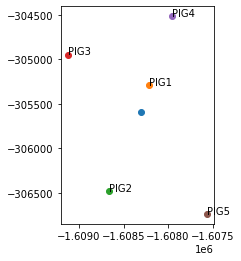

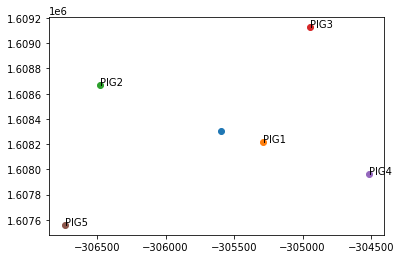

In [80]:
# plot the array in EPSG:3031
l.array_lon_lat_centroid = get_array_centroid(l.station_grid_coords)[0]
l.array_grid_centroid = get_array_centroid(l.station_grid_coords)[1]
labels = ["PIG1","PIG2","PIG3","PIG4","PIG5"]
fig, ax = plt.subplots()
plt.scatter(l.array_grid_centroid[0],l.array_grid_centroid[1])
for i, txt in enumerate(labels):
    plt.scatter(l.station_grid_coords[i,0],l.station_grid_coords[i,1])
    ax.annotate(txt, (l.station_grid_coords[i,0], l.station_grid_coords[i,1]))
ax.set_aspect('equal')
plt.show()

fig, ax = plt.subplots()
plt.scatter(l.array_grid_centroid[1],l.array_grid_centroid[0]*-1)
for i, txt in enumerate(labels):
    plt.scatter(l.station_grid_coords[i,1],l.station_grid_coords[i,0]*-1)
    ax.annotate(txt, (l.station_grid_coords[i,1], l.station_grid_coords[i,0]*-1))
plt.show()


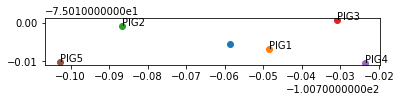

In [57]:
# plot the array in lat lon
l.array_lon_lat_centroid = get_array_centroid(l.station_grid_coords)[0]
l.array_grid_centroid = get_array_centroid(l.station_grid_coords)[1]
labels = ["PIG1","PIG2","PIG3","PIG4","PIG5"]
fig, ax = plt.subplots()
plt.scatter(l.array_lon_lat_centroid[0],l.array_lon_lat_centroid[1])
for i, txt in enumerate(labels):
    plt.scatter(l.station_lon_lat_coords[i,0],l.station_lon_lat_coords[i,1])
    ax.annotate(txt, (l.station_lon_lat_coords[i,0], l.station_lon_lat_coords[i,1]))
ax.set_aspect('equal')
plt.show()

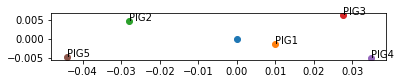

In [61]:
# plot the array in lat lon with origin at array centroid
l.array_lon_lat_centroid = get_array_centroid(l.station_grid_coords)[0]
l.array_grid_centroid = get_array_centroid(l.station_grid_coords)[1]
labels = ["PIG1","PIG2","PIG3","PIG4","PIG5"]
fig, ax = plt.subplots()
plt.scatter(0,0)
for i, txt in enumerate(labels):
    plt.scatter(l.station_lon_lat_coords[i,0]-l.array_lon_lat_centroid[0],l.station_lon_lat_coords[i,1]-l.array_lon_lat_centroid[1])
    ax.annotate(txt, (l.station_lon_lat_coords[i,0]-l.array_lon_lat_centroid[0], l.station_lon_lat_coords[i,1]-l.array_lon_lat_centroid[1]))
ax.set_aspect('equal')

plt.show()

In [75]:
station_lat_diffs

array([-144.90884365,  525.36031401,  692.22998773, -546.84710122,
       -524.63501756])

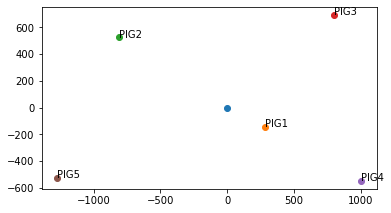

In [95]:
from pyproj import Geod

# use pyproj to estimate meters per degree of longitude and latitude, centered on the array centroid
geod = Geod(ellps="WGS84")
m_per_lon = geod.line_length([l.array_lon_lat_centroid[0]-0.5,l.array_lon_lat_centroid[0]+0.5],[l.array_lon_lat_centroid[1],l.array_lon_lat_centroid[1]])
m_per_lat = geod.line_length([l.array_lon_lat_centroid[0],l.array_lon_lat_centroid[0]],[l.array_lon_lat_centroid[1]-0.5,l.array_lon_lat_centroid[1]+0.5])

# get differences from array centroid in lat/lon and convert to meters
station_lon_diffs = (l.station_lon_lat_coords[:,0]-l.array_lon_lat_centroid[0])*m_per_lon
station_lat_diffs = (l.station_lon_lat_coords[:,1]-l.array_lon_lat_centroid[1])*m_per_lat

# plot the array in m converted from lat lon with origin at array centroid
l.array_lon_lat_centroid = get_array_centroid(l.station_grid_coords)[0]
l.array_grid_centroid = get_array_centroid(l.station_grid_coords)[1]
labels = ["PIG1","PIG2","PIG3","PIG4","PIG5"]
fig, ax = plt.subplots()
plt.scatter(0,0)
for i, txt in enumerate(labels):
    plt.scatter(station_lon_diffs[i],station_lat_diffs[i])
    ax.annotate(txt, (station_lon_diffs[i],station_lat_diffs[i]))
ax.set_aspect('equal')
plt.show()

In [119]:
# THIS CORRECTLY CALCULATES ANGLES IN RELATION TO TRUE NORTH

def get_station_coordinates(l):
    stat_coords = []
    inv = obspy.read_inventory(l.xml_path + "/*")
    channels = inv.get_contents()['channels']
    for channel in channels:
        lat = inv.get_coordinates(channel)["latitude"]
        lon = inv.get_coordinates(channel)["longitude"]
        stat_coords.append([lon,lat])
    _, idx = np.unique(stat_coords,axis=0,return_index=True)
    stat_coords = np.array(stat_coords)[np.sort(idx)]
    return stat_coords





def get_station_grid_locations(l):
    # use pyproj to estimate meters per degree of longitude and latitude, centered on the array centroid
    geod = Geod(ellps="WGS84")
    m_per_lon = geod.line_length([l.array_centroid[0]-0.5,l.array_centroid[0]+0.5],[l.array_centroid[1],l.array_centroid[1]])
    m_per_lat = geod.line_length([l.array_centroid[0],l.array_centroid[0]],[l.array_centroid[1]-0.5,l.array_centroid[1]+0.5])

    # get differences from array centroid in lat/lon and convert to meters
    station_lon_diffs = (l.station_lon_lat_coords[:,0]-l.array_lon_lat_centroid[0])*m_per_lon
    station_lat_diffs = (l.station_lon_lat_coords[:,1]-l.array_lon_lat_centroid[1])*m_per_lat
    return np.stack((station_lon_diffs,station_lat_diffs),axis=1)



def get_station_angles(l):
    station_angles = []
    for i in range(len(l.station_grid_coords)):
        x = (l.station_grid_coords[i,0])
        y = (l.station_grid_coords[i,1])
        angle = np.arctan2(y,x)*180/np.pi
        
        # subtract from 90 since the returned angles are in relation to 0 on the unit circle
        # we want them in relation to grid north for epsg:3031
        angle = 90 - angle
        if angle < 0:
            angle = angle + 360
        
        station_angles.append(angle)
    return station_angles


In [120]:

# get home directory path
home_dir = str(pathlib.Path().absolute())

# get useful geometric information about the array
l.station_lon_lat_coords = get_station_coordinates(l)
l.array_centroid = np.mean(l.station_lon_lat_coords,axis=0)
l.station_grid_coords = get_station_grid_locations(l)
l.station_angles = get_station_angles(l)


In [134]:
def compute_baz_old(component):
    # based on which quadrant we're in, use the appropriate triangle side ratios for arctan
    if component[0] > 0 and component[1] > 0:
        baz = np.arctan(abs(component[0]/component[1]))*180/np.pi
    if component[0] > 0 and component[1] < 0:
        baz = np.arctan(abs(component[1]/component[0]))*180/np.pi + 90
    if component[0] < 0 and component[1] < 0:
        baz = np.arctan(abs(component[0]/component[1]))*180/np.pi + 180
    if component[0] < 0 and component[1] > 0:
        baz = np.arctan(abs(component[1]/component[0]))*180/np.pi + 270
    return baz


In [135]:
def compute_baz_new(component):
    event_baz = 90 - np.arctan2(component[1],component[0])*180/np.pi
    if event_baz < 0:
        event_baz = event_baz + 360
    return event_baz

In [161]:
compute_baz_new([-0.1,-1])

185.71059313749964

In [160]:
compute_baz_old([-0.1,-1])

185.71059313749964

In [ ]:
# get backazimuths for the subarray (PIG2,PIG4,PIG5) and the entire array for a particular pca correction method
baz_file = open("outputs/locations/new_catalog_PIG1_PIG2_PIG3_PIG4_PIG5_new_pca_moving_centroid.pickle", "rb")
b = pickle.load(baz_file)
baz_file.close()
all_array_backazimuths = b.backazimuths
baz_file = open("outputs/locations/new_catalog_PIG2_PIG4_PIG5_new_pca_moving_centroid.pickle", "rb")
b = pickle.load(baz_file)
baz_file.close()
all_subarray_backazimuths = b.backazimuths

# load catalog and detection times
ds = pyasdf.ASDFDataSet("outputs/detections/template_matching_catalog.h5",mode='r')
detection_times = get_detection_times(ds)

# load clustering results
cluster_file = h5py.File("outputs/clustering/2_cluster_results.h5","r")
predictions = np.array(list(cluster_file["cluster_index"]))
centroids = list(cluster_file["centroids"])
cluster_file.close()

array_backazimuths = all_array_backazimuths[predictions == 0]
subarray_backazimuths = all_subarray_backazimuths[predictions == 0]

In [ ]:
# find an event that has a rift tip backazimuth with PIG2,PIG4,PIG5 but a 180 flipped backazimuth when all stations are included
ind = 4290
print(array_backazimuths[ind])
print(subarray_backazimuths[ind])

# get the time for this event
detection_time = detection_times[predictions==0][ind]
print(detection_time)

In [ ]:
# plot it to make sure it has a decent SNR so the exploration of arrival time estimation is meaningful
#fname = "/media/Data/Data/PIG/MSEED/noIR/PIG*/HH*/2013-06-27.PIG*.HH*.noIR.MSEED"
fname = "/media/Data/Data/PIG/MSEED/noIR/PIG*/HH*/2013-05-02.PIG*.HH*.noIR.MSEED"
st = obspy.read(fname)
st.filter("bandpass",freqmin=0.05,freqmax=1.0)
detection_utc_time = obspy.UTCDateTime(detection_time)
st_event = st.copy()
st_event.trim(starttime=detection_utc_time,endtime=detection_utc_time+500)
st_event.taper(max_percentage=0.1, max_length=30.)
st_event.plot();

In [ ]:
from obspy.signal.cross_correlation import correlate
from obspy.signal.cross_correlation import xcorr_max
from collections import Counter

def first_observed_arrival(st):
    # cross correlate all traces and find station with largest shift
    channels = ["HHZ","HHN","HHE"]
    first_stat_vector = []
    for chan in channels:
        st_chan = st.select(channel=chan)
        #st_chan.plot()
        shifts = np.zeros(len(st_chan))
        corrs = np.zeros(len(st_chan))
        for j in range(len(st_chan)):
            corr = correlate(st_chan[0], st_chan[j], 1000)
            shift, correlation_coefficient = xcorr_max(corr,abs_max=True)
            shifts[j] = shift
            corrs[j] = correlation_coefficient
#        print(shifts)
        stat_idx = np.argmax(shifts)
#        print(stat_idx)
#        print(st_chan[stat_idx].stats.station)
        first_stat_vector.append(st_chan[stat_idx].stats.station)
    counts = Counter(first_stat_vector).most_common(2)
    if len(counts) > 1:
        if counts[0][1] == counts[1][1]:
            first_stat = []
        else:
            first_stat = counts[0][0]
    else:
        first_stat = counts[0][0]
#    print(first_stat_vector)
    return first_stat

In [ ]:
# check the result of first arrival estimation for both the subset and whole array
# they probably will be reversed
array_first_arrival = first_observed_arrival(st_event)
print(array_first_arrival)

st_event_subarray = obspy.Stream()
for s in ["PIG2","PIG4","PIG5"]:
    st_event_subarray += st_event.select(station=s)
subarray_first_arrival = first_observed_arrival(st_event_subarray)
print(subarray_first_arrival)

In [ ]:
# plot just the traces from individual stations
st_event.select(station=array_first_arrival).plot();
st_event.select(station=subarray_first_arrival).plot();

In [ ]:
# test first arrival between these two
st_test = st_event.select(station=array_first_arrival)
st_test += st_event.select(station=subarray_first_arrival)
test_first_arrival = first_observed_arrival(st_test)
print(test_first_arrival)

In [ ]:
# check number of quadrant 3 events for subarray vs whole array
print(len(subarray_backazimuths[np.logical_and(subarray_backazimuths > 180,subarray_backazimuths < 270)]))
print(len(array_backazimuths[np.logical_and(array_backazimuths > 180,array_backazimuths < 270)]))

In [ ]:
# check number of quadrant 4 events for subarray vs whole array
print(len(subarray_backazimuths[np.logical_and(subarray_backazimuths > 270,subarray_backazimuths < 360)]))
print(len(array_backazimuths[np.logical_and(array_backazimuths > 270,array_backazimuths < 360)]))

In [ ]:
string_list = ["t","i"]
"o" in string